# Breast Cancer Detection Model Ver01

## 0. Import Module

- [OpenSlide](https://openslide.org/api/python/#module-openslide)

In [93]:
%matplotlib inline
import os
import csv
import cv2
import openslide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from openslide.deepzoom import DeepZoomGenerator

## 1. Data Load

In [2]:
# slide path
slide_path = '../data/train/16-S-042893_A1.mrxs'  # pos
# neg_slide_path = '../data/train/16-S-042725_A.mrxs'  # neg

# mask path
mask_path = '../data/train/Mask_16-S-042893_A1.png'  # pos
# neg_mask_path = '../data/train/Mask_16-S-042725_A.png'  # neg

# openslide
## slide
slide = openslide.open_slide(slide_path)
# neg_slide = openslide.open_slide(neg_slide_path)
## mask
mask = openslide.open_slide(mask_path)
# neg_mask = openslide.open_slide(neg_mask_path)

In [3]:
print('origin pos_slide.dimensions :', slide.dimensions)
# print('origin neg_slide.dimensions :', neg_slide.dimensions)
print('origin pos_mask.dimensions :', mask.dimensions)
# print('origin neg_mask.dimensions :', neg_mask.dimensions)

origin pos_slide.dimensions : (93970, 234042)
origin pos_mask.dimensions : (5316, 10007)


In [4]:
print("pos_slide's num of levels :", slide.level_count)
print("pos_slide's shape of levels :")
for level, dim in enumerate(slide.level_dimensions):
    print("level {} : {}".format(level, dim))

pos_slide's num of levels : 10
pos_slide's shape of levels :
level 0 : (93970, 234042)
level 1 : (46985, 117021)
level 2 : (23492, 58510)
level 3 : (11746, 29255)
level 4 : (5873, 14627)
level 5 : (2936, 7313)
level 6 : (1468, 3656)
level 7 : (734, 1828)
level 8 : (367, 914)
level 9 : (183, 457)


## 2. Fit Data Shape

### 1) Using min x,y offset

In [5]:
# Path size
PATCH_SIZE = 256

# min x,y offset
min_x, min_y = (7744, 39056)
location = (int(min_x), int(min_y))

# size x, y
size = (int(mask.dimensions[0]/16), int(mask.dimensions[1]/16))

# level
level = int(np.log2(PATCH_SIZE))

# read region
slide_lv8 = slide.read_region(location, level, size)

# thumbnail mask
thumbnail_mask = mask.get_thumbnail(size)  # (332, 625)

In [6]:
print('slide_lv8.size :', slide_lv8.size)
print('thumbnail_mask.size :', thumbnail_mask.size)

slide_lv8.size : (332, 625)
thumbnail_mask.size : (332, 624)


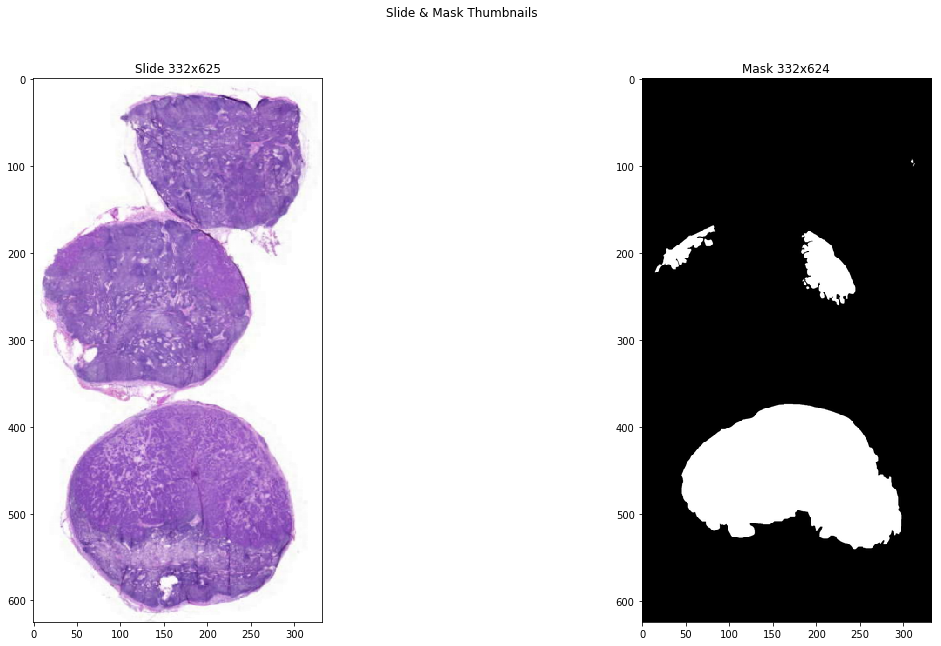

In [7]:
## Plotting
f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(slide_lv8);
ax[0].set_title('Slide %dx%d' % slide_lv8.size)
ax[1].imshow(thumbnail_mask.convert('L'), cmap='gray');
ax[1].set_title('Mask %dx%d' % thumbnail_mask.size)
f.suptitle('Slide & Mask Thumbnails ');

### 2) Without using min x,y offset

In [8]:
min_x = slide.properties.get(
    openslide.PROPERTY_NAME_BOUNDS_X)

In [9]:
min_y = slide.properties.get(
    openslide.PROPERTY_NAME_BOUNDS_Y)

In [10]:
# Path size
PATCH_SIZE = 256

# min x,y offset
# min_x, min_y = (7744, 39056)
location = (int(min_x), int(min_y))

# size x, y
size = (int(mask.dimensions[0]/16), int(mask.dimensions[1]/16))

# level
level = int(np.log2(PATCH_SIZE))

# read region
slide_lv8 = slide.read_region(location, level, size)

# thumbnail mask
thumbnail_mask = mask.get_thumbnail(size)  # (332, 625)

In [11]:
print('slide_lv8.size :', slide_lv8.size)
print('thumbnail_mask.size :', thumbnail_mask.size)

slide_lv8.size : (332, 625)
thumbnail_mask.size : (332, 624)


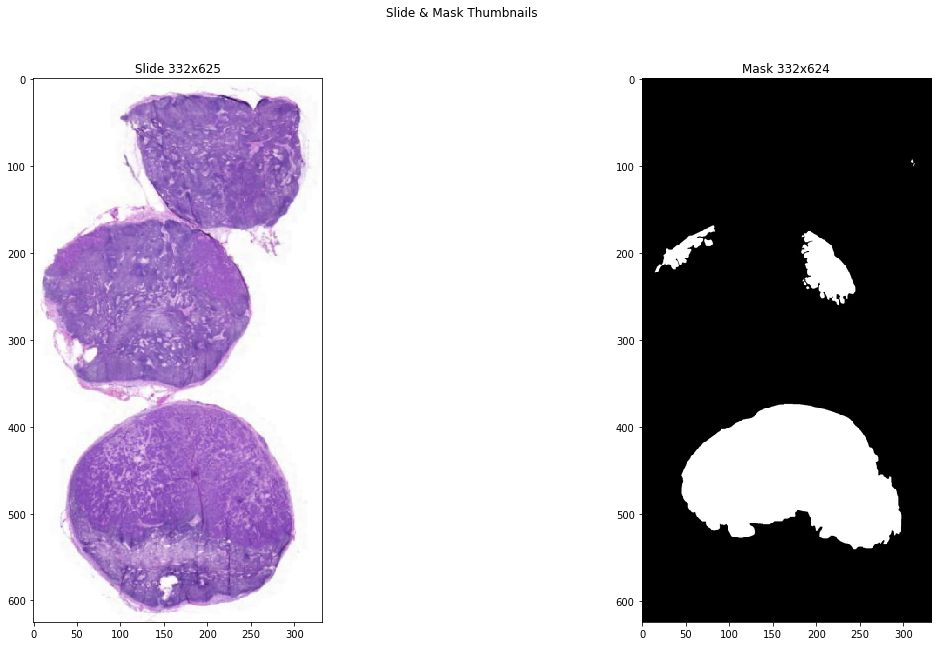

In [12]:
## Plotting
f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(slide_lv8);
ax[0].set_title('Slide %dx%d' % slide_lv8.size)
ax[1].imshow(thumbnail_mask.convert('L'), cmap='gray');
ax[1].set_title('Mask %dx%d' % thumbnail_mask.size)
f.suptitle('Slide & Mask Thumbnails ');

## 3. Patch Gen

### 1) Patch DataFrame

In [13]:
## set params
PATCH_SIZE = 256
IS_TRAIN = True

# Mask는 원본의 1/16
mask_div = int(PATCH_SIZE / 16)
slide_lv8_grey = np.array(slide_lv8.convert('L'))
slide_lv8_nb = slide_lv8_grey[slide_lv8_grey>0]
ret, th = cv2.threshold(slide_lv8_nb, 0, 255, 
                        cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [14]:
binary = slide_lv8_grey > 0
h, w = slide_lv8_grey.shape
for i in range(h):
    for j in range(w):
        if slide_lv8_grey[i, j] > ret:
            binary[i, j] = False

In [15]:
patch_df = pd.DataFrame(pd.DataFrame(binary).stack(), columns=['is_tissue'])
patch_df['slide_path'] = slide_path
patch_df.head()

is_tissue                         slide_path
0 0      False  ../data/train/16-S-042893_A1.mrxs
  1      False  ../data/train/16-S-042893_A1.mrxs
  2      False  ../data/train/16-S-042893_A1.mrxs
  3      False  ../data/train/16-S-042893_A1.mrxs
  4      False  ../data/train/16-S-042893_A1.mrxs

In [16]:
patch_df['is_tissue'].value_counts()

True     109345
False     98155
Name: is_tissue, dtype: int64

In [17]:
# patch_df = pd.DataFrame(pd.DataFrame(th>0).stack(), columns=['is_tissue'])
# patch_df['slide_path'] = slide_path
# patch_df.head()

In [18]:
thumb_size = (mask.dimensions[0]/mask_div, mask.dimensions[1]/mask_div)
mask_thumbnail = mask.get_thumbnail(thumb_size)
mask_thumbnail = np.array(mask_thumbnail.convert('L')).reshape(-1)
mask_thumbnail = mask_thumbnail > 0

# add column patch_df as is_tumor
patch_df['is_tumor'] = mask_thumbnail
patch_df.head()

is_tissue                         slide_path  is_tumor
0 0      False  ../data/train/16-S-042893_A1.mrxs     False
  1      False  ../data/train/16-S-042893_A1.mrxs     False
  2      False  ../data/train/16-S-042893_A1.mrxs     False
  3      False  ../data/train/16-S-042893_A1.mrxs     False
  4      False  ../data/train/16-S-042893_A1.mrxs     False

In [19]:
## Get only tissue
patch_df = patch_df[patch_df['is_tissue'] == True]
print('len of patch_df :', len(patch_df))

len of patch_df : 109345


In [20]:
patch_df.head()

is_tissue                         slide_path  is_tumor
17 165       True  ../data/train/16-S-042893_A1.mrxs     False
   166       True  ../data/train/16-S-042893_A1.mrxs     False
   167       True  ../data/train/16-S-042893_A1.mrxs     False
   201       True  ../data/train/16-S-042893_A1.mrxs     False
   205       True  ../data/train/16-S-042893_A1.mrxs     False

In [21]:
## add tile_loc column
patch_df['tile_loc'] = list(patch_df.index)
patch_df.reset_index(drop=True, inplace=True)
patch_df.head()

,is_tissue,slide_path,is_tumor,tile_loc
0,True,../data/train/16-S-042893_A1.mrxs,False,"(17, 165)"
1,True,../data/train/16-S-042893_A1.mrxs,False,"(17, 166)"
2,True,../data/train/16-S-042893_A1.mrxs,False,"(17, 167)"
3,True,../data/train/16-S-042893_A1.mrxs,False,"(17, 201)"
4,True,../data/train/16-S-042893_A1.mrxs,False,"(17, 205)"


### 2) Create Tiles using DeepZoomGenerator

In [22]:
from openslide.deepzoom import DeepZoomGenerator

In [23]:
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_mask = DeepZoomGenerator(mask, tile_size=16, overlap=0, limit_bounds=False)

In [24]:
start_x = int(slide.properties.get(openslide.PROPERTY_NAME_BOUNDS_X)) / PATCH_SIZE
start_y = int(slide.properties.get(openslide.PROPERTY_NAME_BOUNDS_Y)) / PATCH_SIZE
print('(start_x, start_y) :', (start_x, start_y))

(start_x, start_y) : (30.296875, 152.61328125)


In [25]:
# Shuffle the patch_df
patch_df = patch_df.sample(frac=1, random_state=42)
patch_df.head()

,is_tissue,slide_path,is_tumor,tile_loc
20237,True,../data/train/16-S-042893_A1.mrxs,False,"(132, 284)"
25189,True,../data/train/16-S-042893_A1.mrxs,False,"(165, 191)"
10408,True,../data/train/16-S-042893_A1.mrxs,False,"(77, 214)"
491,True,../data/train/16-S-042893_A1.mrxs,False,"(24, 157)"
26942,True,../data/train/16-S-042893_A1.mrxs,False,"(175, 139)"


In [107]:
batch_size = 32
batch_df = patch_df.iloc[0:batch_size]

batch_tiles, batch_mask = [], []
for y, x in batch_df['tile_loc'].values:
    img = tiles.get_tile(tiles.level_count-1, (x+start_x, y+start_y))
    batch_tiles.append(np.array(img, dtype=int))
    
    mask_tile = tiles_mask.get_tile(tiles_mask.level_count-1, (x, y))
    mask_tile = cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY)
    mask_tile_zoom = cv2.resize(mask_tile, (PATCH_SIZE, PATCH_SIZE), 
                                interpolation=cv2.INTER_LINEAR)
    mask_tile_zoom = mask_tile_zoom.astype(int) / 255
    batch_mask.append(mask_tile_zoom)

In [108]:
# batch_size = 32
# break_cnt = 0
# for offset in range(0, len(patch_df), batch_size):
#     batch_df = patch_df[offset:offset+batch_size]
    
#     break_cnt += 1
#     if break_cnt == 10:
#         break

In [114]:
train_x = np.array(batch_tiles) / 255.
print('train_x.shape :', train_x.shape)

train_y = np.array(batch_mask)
train_y = to_categorical(train_y, num_classes=2)
print('train_y.shape :', train_y.shape)

train_x.shape : (32, 256, 256, 3)
train_y.shape : (32, 256, 256, 2)


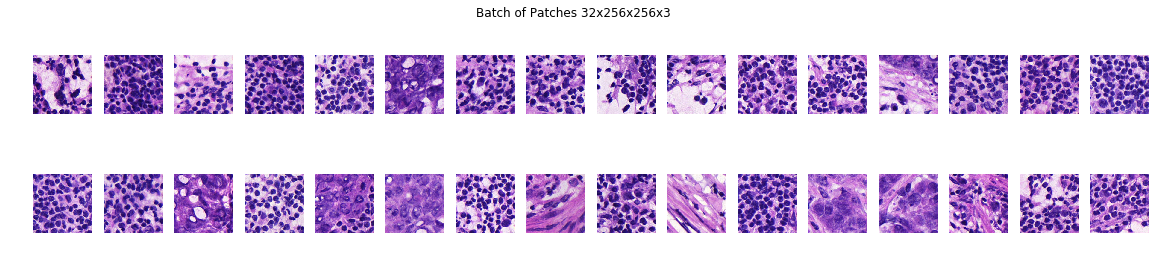

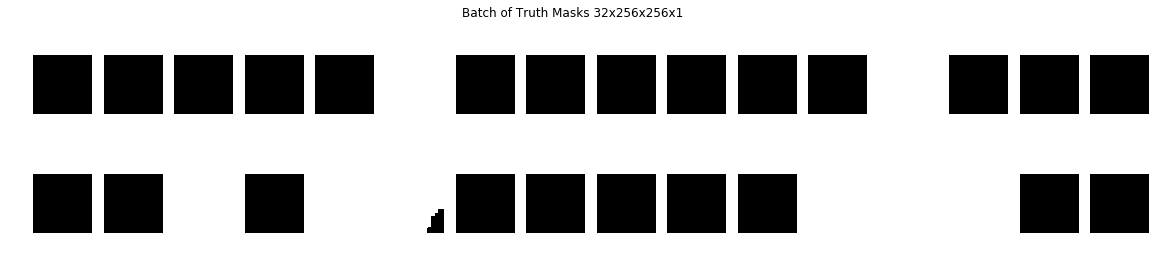

In [117]:
f, axes = plt.subplots(2, 16, figsize=(20, 4));
ax = axes.flatten()
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_x[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(2, 16, figsize=(20, 4));
ax = axes.flatten()    
for i in range(0, train_x.shape[0]):
    _ = ax[i].imshow(train_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');